# Root fit analyzing neural network


By Brady Lowe

lowebra2@isu.edu

7/25/2018


This Jupyter notebook was written to both develope and explain how we can use
neural networks to analyze the output of root fits to raw data.

### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
# Personal functions
import nn_utils

%matplotlib inline

Using TensorFlow backend.


### Select and load dataset

In [30]:
# Select and load dataset
x, y, files = nn_utils.load_dataset(im_dir="dev", return_filenames=True)

# Print dimensions
m, h, w, c = x.shape
print(str(m) + " images loaded of shape (" + str(h) + ", " + str(w) + ", " + str(c) + ")")

465 images loaded of shape (236, 348, 3)


### Load Model

In [3]:
# load json and create model
json_file = open('trained/conv_model_500.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_500.h5")
print("Loaded model from disk")

# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']

# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
print("Model compiled")

Loaded model from disk
Model compiled


### Evaluate dataset using model

In [43]:
# Evaluate model, get metrics back
stats = model.evaluate(x, y)
# Calculate predictions vector from model
predictions = model.predict(x)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(np.floor(predictions + 0.5), good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on DEV set")
print("..........................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
positive_list = []
negative_list = []
unsure_list = []
for i in range(m):
    if wrong_answers[i] == 1:
        bad_list.append(i)
    if predictions[i] > 0.5:
        positive_list.append(i)
    else:
        negative_list.append(i)
    if predictions[i] > 0.2 and predictions[i] < 0.8:
        unsure_list.append(i)
print("..........................")
print("List of indices of positive predictions:")
print(positive_list)
print("..........................")
print("List of indices of negative predictions:")
print(negative_list)
print("..........................")
print("List of indices of uncertain predictions:")
print(unsure_list)
print("..........................")
print("List of indices of wrong guesses:")
print(bad_list)
print("..........................")

465/465 [==============================] - 1s 2ms/step

Performance on DEV set
..........................
Loss: 0.0554360314723
Accuracy: 0.939784946493
Precision: 0.994186046512
Recall: 0.929347826087
..........................
List of indices of positive predictions:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 32, 34, 35, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 108, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 1

### Make changes to the dataset 

#### Loop through network's incorrect predictions (or select an index)

images/dev\fit_pmt_nn__run372_chi10_time20180731225311857_label0.png
label: [0]
prediction: [ 0.62179732]


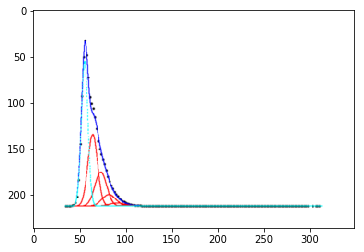

In [54]:
# Choose an index
index = 452
# Print filename
print(files[index])
# Print labels for this index
print("label: " + str(y[index]))
print("prediction: " + str(predictions[index]))
# Show image
plt.imshow(np.uint8(nn_utils.get_printable_image(x[index])))

In [38]:
# Change the label
if False:
    nn_utils.change_label(files[index])
    print("Label changed for index " + str(index))

Label changed for index 37


#### Loop through the positive/negative predictions

In [35]:
# Choose positives (+1) or negatives (-1)
choice = 1

# Loop through all images
for i in range(m):
    # Select the predictions of interest (pos or neg)
    if (predictions[i] > 0.5 and choice == 1) or (predictions[i] < 0.5 and choice == -1):
        # Print out info and image
        print(files[i])
        print("label: " + str(y[i]))
        plt.imshow(np.uint8(nn_utils.get_printable_image(x[index])))
        
    # Print user options
    print("Type one of the following:")
    print("  <Enter> - to continue to the next image")
    print("  change  - to change the label of the current index")
    print("  exit    - to quit looping")
    user_info = raw_input("Type \"exit\" to exit, or \"enter\" to continue")
    if user_info == "exit":
        break;
    if user_info == "change":
        nn_utils.change_label(files[i])
        print("Label changed for index " + str(i))
    
        
    

NameError: name 'array' is not defined